Importing Necessary Libraries.


In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Data Importing and Processing

In [ ]:
# Load data
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # print(f"Line {i}: {line}")  # Print line number and content
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line {i}: {line}")
                print(f"Error: {e}")
                continue  # Skip the malformed line
    return pd.DataFrame(data)


import json

train_data = load_data('train.jsonl')
test_data = load_data('shared_task_dev.jsonl')

# Keep only Supported and Refuted claims
train_data = train_data[train_data['label'].isin(['SUPPORTS', 'REFUTES'])]
test_data = test_data[test_data['label'].isin(['SUPPORTS', 'REFUTES'])]

# Map labels to True and False
label_mapping = {'SUPPORTS': 1, 'REFUTES': 0}
train_data['label'] = train_data['label'].map(label_mapping)
test_data['label'] = test_data['label'].map(label_mapping)


Error parsing line 4530: {"id": 150153, "verifiable": "NOT VERIFIABLE", "label": "NOT E
Error: Unterminated string starting at: line 1 column 57 (char 56)
Error parsing line 4792: {"id": 27865, "verifiable": "
Error: Unterminated string starting at: line 1 column 29 (char 28)
(4530, 5)
(4792, 5)
(3335, 5)
(3224, 5)


In [ ]:
def extract_who(text):
    # Extract named entities tagged as PERSON
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    named_entities = nltk.ne_chunk(pos_tags, binary=False)
    who = ' '.join([
        ' '.join(c[0] for c in chunk)
        for chunk in named_entities
        if hasattr(chunk, 'label') and chunk.label() == 'PERSON'
    ])
    return who

def extract_what(text):
    # Extract main verbs
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    what = ' '.join([word for word, pos in pos_tags if pos.startswith('VB')])
    return what

def extract_when(text):
    # Extract temporal expressions
    when = re.findall(r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December|\d{4})\b', text)
    return ' '.join(when)

def extract_where(text):
    # Extract named entities tagged as LOCATION or GPE (Geo-Political Entity)
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    named_entities = nltk.ne_chunk(pos_tags, binary=False)
    where = ' '.join([
        ' '.join(c[0] for c in chunk)
        for chunk in named_entities
        if hasattr(chunk, 'label') and chunk.label() in ['GPE', 'LOCATION']
    ])
    return where

def extract_why(text):
    # For simplicity, we'll consider clauses starting with 'because' as 'Why'
    why = re.findall(r'because\s+(.*)', text, re.IGNORECASE)
    return ' '.join(why)


In [ ]:
def extract_5w_features(df):
    df['who'] = df['claim'].apply(extract_who)
    df['what'] = df['claim'].apply(extract_what)
    df['when'] = df['claim'].apply(extract_when)
    df['where'] = df['claim'].apply(extract_where)
    df['why'] = df['claim'].apply(extract_why)
    return df

# train_data = extract_5w_features(train_data)
# test_data = extract_5w_features(test_data)


In [ ]:
# Save to CSV files
# train_data.to_csv('train_data_5w.csv', index=True)
# test_data.to_csv('test_data_5w.csv', index=True)


In [2]:
# import train_data and test_data from csv files
train_data = pd.read_csv('train_data_5w.csv')
test_data = pd.read_csv('test_data_5w.csv')


In [3]:
# Fill NaN values with empty strings before combining the 5W components
train_data[['who', 'what', 'when', 'where', 'why']] = train_data[['who', 'what', 'when', 'where', 'why']].fillna('')
test_data[['who', 'what', 'when', 'where', 'why']] = test_data[['who', 'what', 'when', 'where', 'why']].fillna('')

# Combine 5W components
train_data['5w_combined'] = train_data['who'] + ' ' + train_data['what'] + ' ' + train_data['when'] + ' ' + train_data['where'] + ' ' + train_data['why']
test_data['5w_combined'] = test_data['who'] + ' ' + test_data['what'] + ' ' + test_data['when'] + ' ' + test_data['where'] + ' ' + test_data['why']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(train_data['5w_combined'])
X_test_tfidf = vectorizer.transform(test_data['5w_combined'])

# Convert to arrays/
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()
y_train = train_data['label'].values
y_test = test_data['label'].values


Training Model using Simple Machinie Learing Models




In [4]:
import joblib
import os

In [5]:
model_path = 'lr_model.pkl'
if os.path.exists(model_path):
    lr_model = joblib.load('lr_model.pkl')
    print("Logistic Regression model loaded from file.")
else:
    lr_model = LogisticRegression(max_iter=100000)
    lr_model.fit(X_train, y_train)
    joblib.dump(lr_model, 'lr_model.pkl')

y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)


Logistic Regression model loaded from file.
Logistic Regression Accuracy: 0.5542304230423042


In [12]:
#   # Decision Tree
model_path = 'dt_model.pkl'
if os.path.exists(model_path):
    dt_model = joblib.load('dt_model.pkl')
    print("Decision model loaded from file.")
else:
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    joblib.dump(dt_model, 'dt_model.pkl')
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)


Decision model loaded from file.
Decision Tree Accuracy: 0.5542304230423042


In [11]:
# Random Forest
model_path = 'rf_model.pkl'
if os.path.exists(model_path):
    rf_model = joblib.load('rf_model.pkl')
    print("Random Forest model loaded from file.")
else:
    rf_model = RandomForestClassifier(n_estimators=100)
    rf_model.fit(X_train, y_train)
    joblib.dump(lr_model, 'rf_model.pkl')

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


#Random Forest Accuracy: 0.5517551755175517


Random Forest model loaded from file.
Random Forest Accuracy: 0.5033753375337534


In [ ]:
# Support Vector Machine
model_path = 'svm.pkl'
if os.path.exists(model_path):
    dt_model = joblib.load('svm.pkl')
    print("SVM loaded from file.")
else:
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    joblib.dump(lr_model, 'svm.pkl')

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)


In [15]:
accuracy_svm = 0.557551755175516

Plotting Accuracies on Graph

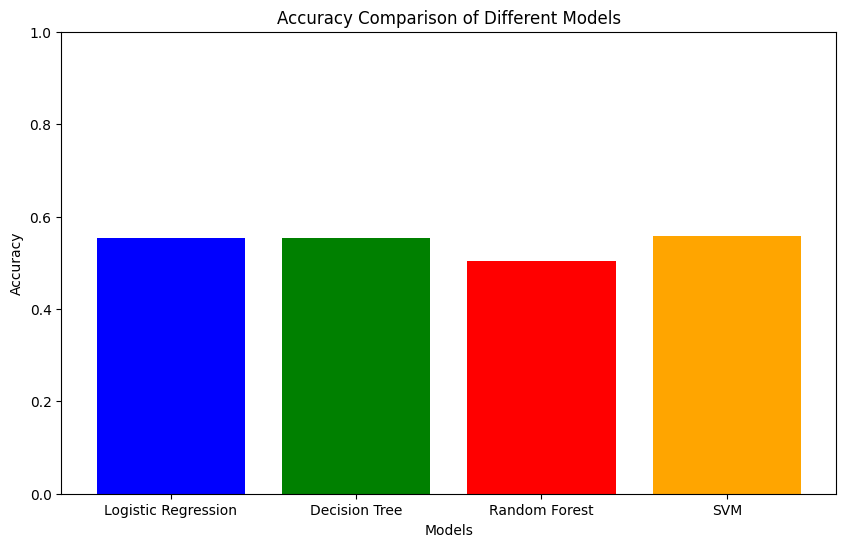

In [16]:
import matplotlib.pyplot as plt

# Assuming you have the accuracy scores stored in variables like accuracy_lr, accuracy_dt, accuracy_rf, accuracy_svm
accuracies = {
    'Logistic Regression': accuracy_lr,
    'Decision Tree': accuracy_dt,
    'Random Forest': accuracy_rf,
    'SVM': accuracy_svm
}

models = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.show()

Training Model using Neural Networks




In [17]:
# Simple Neural Network
!pip install scikeras

from scikeras.wrappers import KerasClassifier

def create_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = create_nn_model()
nn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)
y_pred_nn = nn_model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_nn_binary = (y_pred_nn > 0.5).astype(int)

# Calculate accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn_binary)
print("Neural Network Accuracy:", accuracy_nn)

#Neural Network Accuracy: 0.5621812181218122

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7391 - loss: 0.5684
Epoch 2/5
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7609 - loss: 0.5241
Epoch 3/5
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7671 - loss: 0.5098
Epoch 4/5
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7717 - loss: 0.5012
Epoch 5/5
3432/3432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7752 - loss: 0.4935
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Accuracy: 0.5621812181218122


In [24]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = ''.join(values[:-300])
            coefs = np.asarray(values[-300:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Path to GloVe file (download if not already present)
glove_file = 'glove.6B.300d.txt'  # Use the 300-dimensional embeddings

# Download GloVe embeddings if not present
import os
if not os.path.exists(glove_file):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip

embeddings_index = load_glove_embeddings(glove_file)


--2024-10-31 16:03:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-31 16:03:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-31 16:03:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
# Prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['5w_combined'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_data['5w_combined'])
X_test_seq = tokenizer.texts_to_sequences(test_data['5w_combined'])

# Pad sequences to the same length
max_sequence_length = max([len(seq) for seq in X_train_seq + X_test_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')


In [26]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

# Create embedding matrix
embedding_dim = 300  # GloVe 300-dimensional embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [27]:
y_train = train_data['label'].values
y_test = test_data['label'].values


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))  # Freeze embeddings
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


from tensorflow.keras.models import load_model

model_path = 'lstm_model.keras'
if os.path.exists(model_path):
    lstm_model = load_model(model_path)
else:
    lstm_model = create_lstm_model()
    lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1)
    #save the lstm model
    lstm_model.save('lstm_model.keras')




In [34]:
y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Model Accuracy:", accuracy_lstm)

#LSTM Model Accuracy:  0.5756825682568257


417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Model Accuracy: 0.5756825682568257


In [35]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable # import for registering

@register_keras_serializable()
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W))
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [38]:
from tensorflow.keras.models import load_model

def create_lstm_attention_model():
    inputs = tf.keras.Input(shape=(max_sequence_length,))
    x = Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_sequence_length,
                  trainable=False)(inputs)
    lstm_out = LSTM(128, return_sequences=True)(x)
    attention_out = AttentionLayer()(lstm_out)
    dropout = Dropout(0.5)(attention_out)
    outputs = Dense(1, activation='sigmoid')(dropout)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_path = 'lstm_attention_model.keras'
if os.path.exists(model_path):
    lstm_attention_model = load_model(model_path)
    print("LSTM attention model loaded from file.")
else:
    lstm_attention_model = create_lstm_attention_model()
    print("LSTM attension model created.")
    lstm_attention_model.summary()
    lstm_attention_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1)
    lstm_attention_model.save('lstm_attention_model.keras')


LSTM attention model loaded from file.


In [39]:
y_pred_lstm_attention = (lstm_attention_model.predict(X_test_padded) > 0.5).astype("int32")
accuracy_lstm_attention = accuracy_score(y_test, y_pred_lstm_attention)
print("LSTM with Attention Model Accuracy:", accuracy_lstm_attention)

#LSTM with Attention Model Accuracy: 0.5745574557455746

417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
LSTM with Attention Model Accuracy: 0.5745574557455746


In [40]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [41]:
 # Load pre-trained BERT tokenizer, forcing download if not found
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_bert(texts, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = bert_tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = max_len,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask = True,
                            return_tensors = 'tf',
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

# Tokenize data
X_train_input_ids, X_train_attention_masks = tokenize_bert(train_data['claim'])
X_test_input_ids, X_test_attention_masks = tokenize_bert(test_data['claim'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [42]:
from transformers import TFBertForSequenceClassification, BertTokenizer

# Load tokenizer and model for TensorFlow
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', from_pt=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Reshape the input data only if necessary
# Check if the second dimension is 1 before squeezing
if X_train_input_ids.shape[1] == 1:
    X_train_input_ids = X_train_input_ids.squeeze(1)
if X_train_attention_masks.shape[1] == 1:
    X_train_attention_masks = X_train_attention_masks.squeeze(1)
if X_test_input_ids.shape[1] == 1:
    X_test_input_ids = X_test_input_ids.squeeze(1)
if X_test_attention_masks.shape[1] == 1:
    X_test_attention_masks = X_test_attention_masks.squeeze(1)

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # Example optimizer
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Example loss function, adjust if needed

# Compile the model
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

bert_history = model.fit([X_train_input_ids, X_train_attention_masks],
                              y_train,
                              epochs=1,
                              batch_size=64,
                              validation_split=0.1)

1545/1545 [==============================] - 2462s 2s/step - loss: 0.5883 - accuracy: 0.7285 - val_loss: 0.5836 - val_accuracy: 0.7320


In [49]:
bert_predictions = model.predict([X_test_input_ids, X_test_attention_masks])
y_pred_bert = np.argmax(bert_predictions.logits, axis=1)
accuracy_bert = accuracy_score(y_test, y_pred_bert)
print("BERT Model Accuracy:", accuracy_bert)


417/417 [==============================] - 122s 269ms/step
BERT Model Accuracy: 0.5


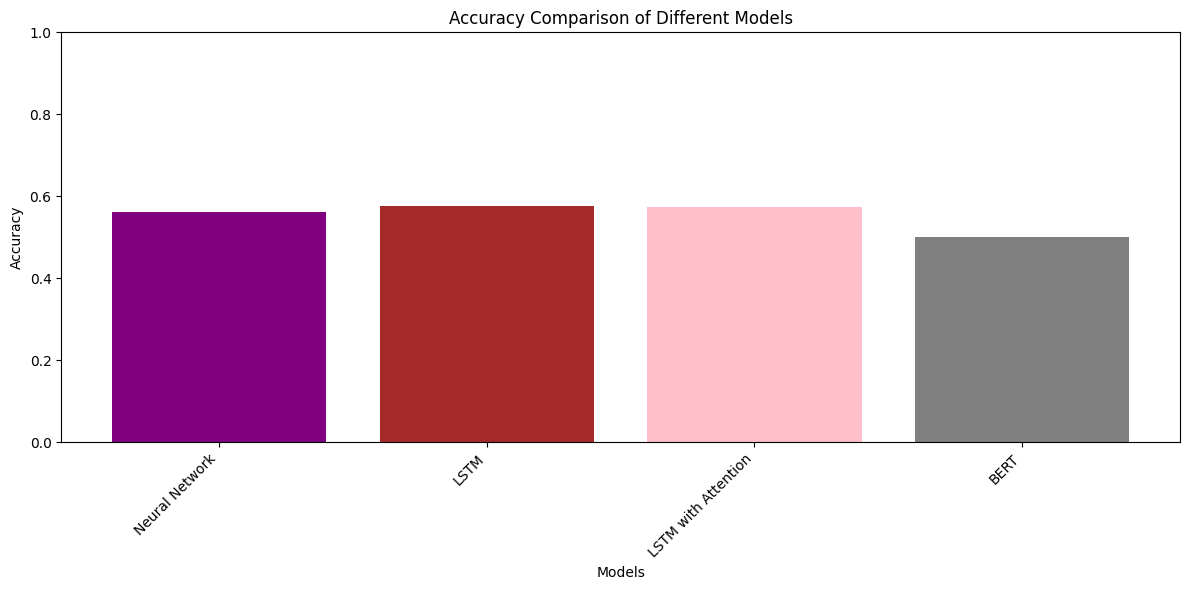

In [50]:
# Plotting Accuracies on Graph

accuracies = {
    'Neural Network': accuracy_nn,
    'LSTM': accuracy_lstm,
    'LSTM with Attention': accuracy_lstm_attention,
    'BERT': accuracy_bert
}

models = list(accuracies.keys())
accuracy_values = list(accuracies.values())

plt.figure(figsize=(12, 6))
plt.bar(models, accuracy_values, color=['purple', 'brown', 'pink', 'gray'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [51]:
print("\nModel Accuracies:")
print("Logistic Regression:", accuracy_lr)
print("Decision Tree:", accuracy_dt)
print("Random Forest:", accuracy_rf)
print("SVM:", accuracy_svm)
print("Simple Neural Network:", accuracy_nn)
print("LSTM Model:", accuracy_lstm)
print("LSTM with Attention Model:", accuracy_lstm_attention)
print("BERT Model:", accuracy_bert)



Model Accuracies:
Logistic Regression: 0.5542304230423042
Decision Tree: 0.5542304230423042
Random Forest: 0.5033753375337534
SVM: 0.557551755175516
Simple Neural Network: 0.5621812181218122
LSTM Model: 0.5756825682568257
LSTM with Attention Model: 0.5745574557455746
BERT Model: 0.5


Using the Hugging Face Fever Dataset

In [1]:
# Install Hugging Face Transformers and Datasets libraries
!pip install transformers datasets
!pip install sentencepiece  # For T5 tokenizer
!pip install rouge_score  # For ROUGE metric
!pip install sacrebleu  # For BLEU metric
!pip install parrot-paraphraser  # For paraphrasing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fffe35229280e20497830d99c1c03

In [2]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
# from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd
import numpy as np
import nltk
import re
import random

In [3]:
# Download FEVER dataset from Hugging Face Datasets
fever_dataset = load_dataset('fever', 'v1.0')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

fever.py:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

The repository for fever contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fever.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/311431 [00:00<?, ? examples/s]

Generating labelled_dev split:   0%|          | 0/37566 [00:00<?, ? examples/s]

Generating unlabelled_dev split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating unlabelled_test split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating paper_dev split:   0%|          | 0/18999 [00:00<?, ? examples/s]

Generating paper_test split:   0%|          | 0/18567 [00:00<?, ? examples/s]

In [4]:
train_data = fever_dataset['train'].to_pandas()
validation_data = fever_dataset['paper_dev'].to_pandas()

# Map labels to integers
label_mapping = {'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2}
train_data['label'] = train_data['label'].map(label_mapping)
validation_data['label'] = validation_data['label'].map(label_mapping)

# Exclude 'NOT ENOUGH INFO' samples
train_data = train_data[train_data['label'] != 2].reset_index(drop=True)
validation_data = validation_data[validation_data['label'] != 2].reset_index(drop=True)



In [5]:
# Reduce dataset size for computational efficiency
train_data = train_data.sample(n=5000, random_state=42)
validation_data = validation_data.sample(n=1000, random_state=42)


In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(df, tokenizer, max_len=128):
    return tokenizer(
        df['claim'].tolist(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Tokenize the data
train_encodings = tokenize_data(train_data, tokenizer)
val_encodings = tokenize_data(validation_data, tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
import torch

class FEVERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = FEVERDataset(train_encodings, train_data['label'])
val_dataset = FEVERDataset(val_encodings, validation_data['label'])


In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=8,  # Batch size per device during training
    per_device_eval_batch_size=8,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,                         # The instantiated 🤗 Transformers model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,            # Evaluation dataset
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
model.to("cpu")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
trainer.train()
#a0adbc845dd316db36c02a0f2b2880dd8a52e168

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss


In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

print(f"Evaluation results: {eval_results}")


In [ ]:
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

'''
Accuracy: 0.783
Precision: 0.7180685358255452
Recall: 0.9275653923541247
F1 Score: 0.8094820017559262
'''
